# Testing code for cost function "elasticity" on the annulus

In [1]:
%pylab inline

import dionysus

Populating the interactive namespace from numpy and matplotlib


## Constructing the annulus and combuting the cocycle

(-2.0570882084951445,
 2.199626142696939,
 -2.1462938955434394,
 2.1901030883462775)

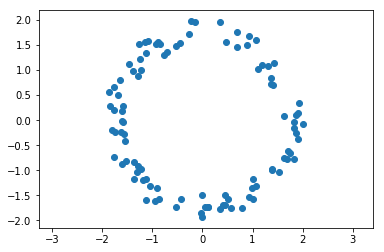

In [2]:
R = 1.5
d = .5
n = 100

# r in [0,1]
# th in [0,2pi)

from math import sin, cos, pi
from random import uniform
def rand_annulus_pt():
    r = uniform(0,1)
    th = uniform(0,2*pi)
    return (R+r*d) * cos(th), (R+r*d) * sin(th)
annulus = np.array([(rand_annulus_pt()) for x in range(100)])
plt.scatter(*annulus.T)
plt.axis('equal')

In [3]:
prime = 19
vr = dionysus.fill_rips(annulus, 2, 4.)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)

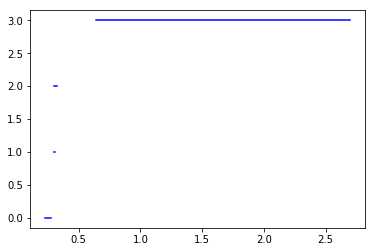

In [4]:
dionysus.plot.plot_bars(dgms[1], show=True)

In [5]:
bars = [bar for bar in dgms[1] if bar.death > 1.]
bars

[(0.64102,2.69627)]

In [6]:
cocycles = [cp.cocycle(bar.data) for bar in bars]
vr_8 = dionysus.Filtration([s for s in vr if s.data <= 1.0])
coords = [dionysus.smooth(vr_8, cocycle, prime) for cocycle in cocycles]

(-2.0570882084951445,
 2.199626142696939,
 -2.1462938955434394,
 2.1901030883462775)

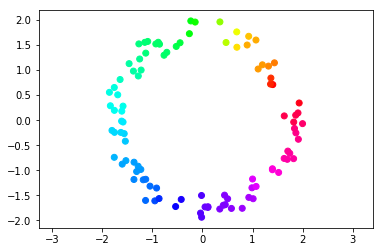

In [7]:
# subplot(121)#, projection="3d")
scatter(*annulus.T, c=coords[0], cmap="hsv")
plt.axis('equal')

# subplot(122)#, projection="3d")
# scatter(*annulus.T, c=coords[1], cmap="hsv")

# Scipy Test

In [30]:
D = {}
data = {}
indexing = {}
ix = [0]*50
thr = 3
for s in vr:
    if s.dimension() == 0:
        continue
    elif s.data > thr:
        break
    D.setdefault(s.dimension(),[[],[]])
    data.setdefault(s.dimension(),[])
    indexing.setdefault(s.dimension(),{})
    indexing.setdefault(s.dimension()-1,{})
    if not s in indexing[s.dimension()]:
        indexing[s.dimension()][s] = ix[s.dimension()]
        ix[s.dimension()] += 1
    for dat, k in enumerate(s.boundary()): 
        if not k in indexing[s.dimension()-1]:
            indexing[s.dimension()-1][k] = ix[s.dimension()-1]
            ix[s.dimension()-1] += 1
        D[s.dimension()][0].append(indexing[s.dimension()][s]) #rows
        D[s.dimension()][1].append(indexing[s.dimension()-1][k]) #cols
        data[s.dimension()].append(1. if dat % 2 == 0 else -1.)
import scipy as sp
CBd = [sp.sparse.csr_matrix((data[d], (D[d][0], D[d][1]))).todense() for d in range(1,max(D.keys())+1)]

In [31]:
from scipy.optimize import minimize

In [37]:
l2_cocycle = [0]*len(coords[0])
for i, coeff in enumerate(coords[0]):
    l2_cocycle[indexing[0][dionysus.Simplex([i],0)]] = coeff
l2_cocycle = np.array(l2_cocycle)
bdry = CBd[0]
n, m = CBd[0].shape
f = np.zeros((n,1))
for c2 in cocycles[0]:
    f[indexing[1][vr[c2.index]]] = c2.element

In [123]:
def grad(Z,L = 1.,F = f, B = bdry):
    coeff_A = 2 + L/np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=2)
    dz = B*Z.reshape(Z.shape[0],1)
    return np.array(coeff_A * B.T * dz - 2 * np.diag(Z) * B.T * F).flatten()

In [124]:
grad(l2_cocycle)

array([ 9.61374494e+00,  9.61374494e+00,  2.40789857e+01,  5.53266470e+01,
       -2.19256587e+00, -2.19256587e+00,  1.15684331e+01,  1.94424398e+01,
       -2.40071391e-01, -2.40071391e-01, -8.58660931e+01, -8.64580355e+01,
       -2.36132286e+00, -2.22167623e+00,  1.01749874e+01, -2.40071391e-01,
        2.38339414e+01,  9.66310502e+01,  2.10609953e+00,  1.68393787e+00,
       -1.37240119e+00, -2.88260986e+00,  2.84896878e+01,  9.93012522e+01,
        3.56072530e+01,  7.13088881e+01, -3.04924733e+00, -1.82888321e+00,
       -8.44841962e+00, -8.44841962e+00, -4.52213006e+00, -4.43820563e+00,
        4.38709359e+00,  2.96103891e+00,  3.21354831e+01,  2.79344210e+01,
        4.23170838e+00, -8.04973328e+00,  1.26654602e+01,  1.95262219e+01,
        4.10037005e+01,  3.69526584e+01, -2.49535706e+00,  2.32194587e+01,
        2.02638630e+01,  4.11819304e-01, -2.05650707e+00, -2.46620229e+00,
       -2.86785458e+00,  1.06315728e+01, -9.61762272e-01, -5.92820278e-01,
        1.55029195e+00, -

In [125]:
def cost(Z,L = 1.,F = f, B = bdry):
    return np.sum(np.square(F - B*Z.reshape(Z.shape[0],1))) + L*np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=2)

In [126]:
cost(l2_cocycle)
# ??dionysus.smooth

18068.77566253151

In [127]:
res = minimize(cost, l2_cocycle, method='BFGS', jac = grad)

Text(0.5, 1.0, 'smoothed values mod 1')

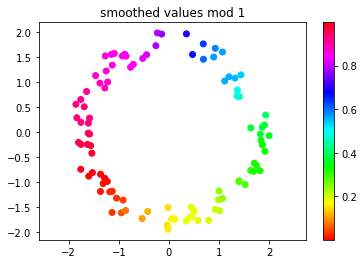

In [131]:
Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = np.mod(Zv.T[:,messed_ix],1)
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values mod 1')

Text(0.5, 1.0, 'smoothed values')

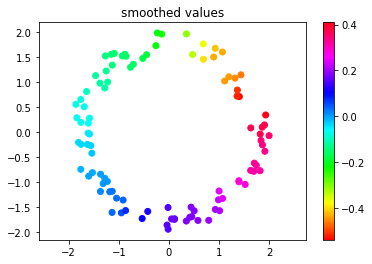

In [132]:
Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = Zv.T[:,messed_ix]
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values')